In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler  # Importar MinMaxScaler
import random
import matplotlib.pyplot as plt 
from tifffile import imwrite
from tensorflow.keras.utils import to_categorical
import glob
import splitfolders

2025-04-27 12:53:34.546885: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 12:53:34.724261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745751214.786905   23866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745751214.802356   23866 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745751214.918266   23866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Definir el escalador
scaler = MinMaxScaler()

# Ruta al conjunto de datos de BraTS2024
#TRAIN_DATASET_PATH = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData/'
TRAIN_DATASET_PATH = 'data/test/'

### Mostrar para una imagen

In [47]:
# Función para cargar y escalar las imágenes de MRI
def load_and_scale_image(file_path):
    """
    Carga una imagen NIfTI (.nii/.nii.gz) y la escala usando MinMaxScaler.
    """
    # Cargar la imagen
    image = nib.load(file_path).get_fdata()
    
    # Escalar la imagen. Aplanamos la imagen a un vector para aplicar el escalado, 
    # luego la reconfiguramos a su forma original.
    image_scaled = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    
    return image_scaled

# Cargar y escalar las imágenes de las distintas modalidades
# Estas son las modalidades del dataset BraTS2025 para este ejemplo

# FLAIR: T2f Fluid-Attenuated Inversion Recovery 
test_image_flair = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz')
print("T2f - FLAIR Image Max Value (after scaling):", test_image_flair.max())

# T1 Non-contrast: T1 sin contraste
test_image_t1 = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz')
print("T1n - T1 Native / Non-contrast Image Max Value (after scaling):", test_image_t1.max())

# T1 Contrast Enhanced: T1 con contraste
test_image_t1ce = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii.gz')
print("t1c - T1 Contrast Enhanced Image Max Value (after scaling):", test_image_t1ce.max())

# T2w Weighted: T2w ponderado
test_image_t2w = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz')
print("t2w - T2 Weighted Image Max Value (after scaling):", test_image_t2w.max())

# Cargar la máscara de segmentación
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz').get_fdata()

# Asegurarnos de que la máscara esté en formato uint8 (para asegurar que las etiquetas sean de 0-255)
test_mask = test_mask.astype(np.uint8)

# Verificar las etiquetas presentes en la máscara
print("Unique mask values (before reencoding):", np.unique(test_mask))  # Deberían ser [0, 1, 2, 4]

T2f - FLAIR Image Max Value (after scaling): 1.0
T1n - T1 Native / Non-contrast Image Max Value (after scaling): 1.0
t1c - T1 Contrast Enhanced Image Max Value (after scaling): 1.0
t2w - T2 Weighted Image Max Value (after scaling): 1.0
Unique mask values (before reencoding): [0 1 2 3]


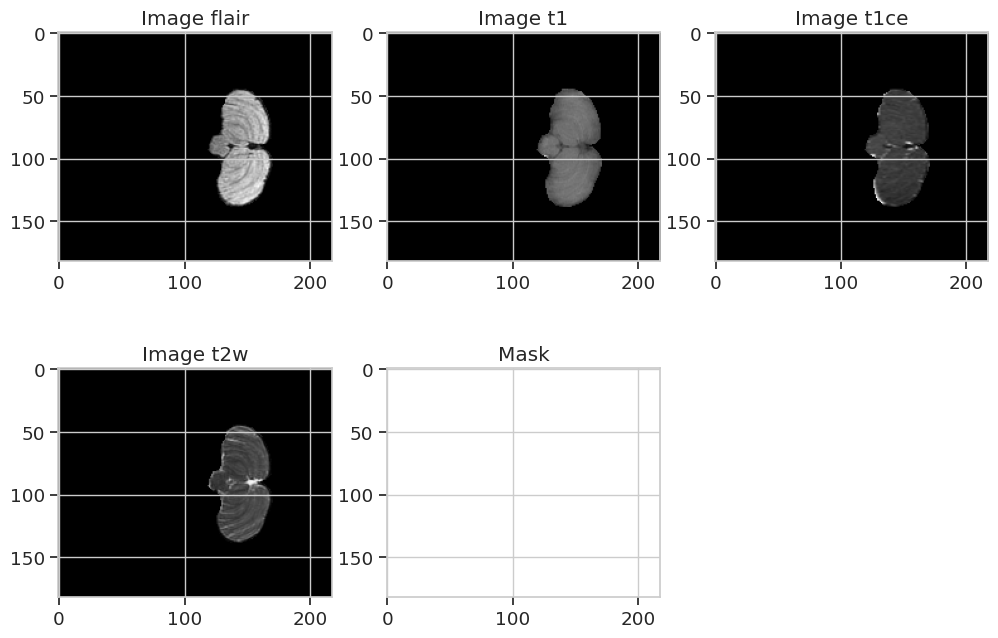

In [69]:
# Mostrar una imagen aleatoria
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2w[:,:,n_slice], cmap='gray')
plt.title('Image t2w')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

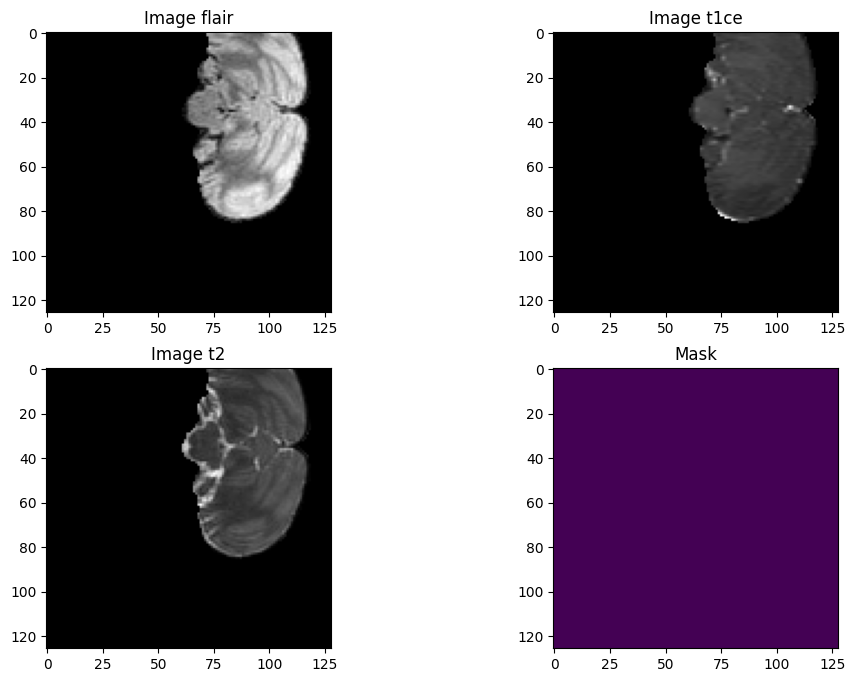

In [ ]:
'''Combining all 4 images to 4 channels of a numpy array.
Combine t1ce, t2w, and t2f into single multichannel image
'''
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2w], axis=3)

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

test_mask = test_mask[56:184, 56:184, 13:141]#The same for mask


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image t2f')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2w')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [9]:
# Asegurarse de que el directorio de salida exista
output_dir = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData-Combined/'
os.makedirs(output_dir, exist_ok=True)

# Guardar archivos multicanal como .tif y .npy
imwrite(os.path.join(output_dir, 'combined-0000-000.tif'), combined_x)
np.save(os.path.join(output_dir, 'combined-0000-000.npy'), combined_x)  # Guardar como np array

# Cargar el archivo guardado como ejemplo
my_img = np.load(os.path.join(output_dir, 'combined-0000-000.npy'))

# Convertir la máscara a formato categórico
test_mask = to_categorical(test_mask, num_classes=4)


### Todas las imágenes

In [3]:
#All images TRAINING
t2w_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t2w.nii.gz'))
t1c_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t1c.nii.gz'))
t1n_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t1n.nii.gz'))
t2f_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t2f.nii.gz'))
mask_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*seg.nii.gz'))

In [4]:
for img in range(len(t2w_list_training)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2w=nib.load(t2w_list_training[img]).get_fdata()
    temp_image_t2w=scaler.fit_transform(temp_image_t2w.reshape(-1, temp_image_t2w.shape[-1])).reshape(temp_image_t2w.shape)
   
    temp_image_t1c=nib.load(t1c_list_training[img]).get_fdata()
    temp_image_t1c=scaler.fit_transform(temp_image_t1c.reshape(-1, temp_image_t1c.shape[-1])).reshape(temp_image_t1c.shape)
    
    temp_image_t1n=nib.load(t1c_list_training[img]).get_fdata()
    temp_image_t1n=scaler.fit_transform(temp_image_t1n.reshape(-1, temp_image_t1n.shape[-1])).reshape(temp_image_t1n.shape)
   
    temp_image_t2f=nib.load(t2f_list_training[img]).get_fdata()
    temp_image_t2f=scaler.fit_transform(temp_image_t2f.reshape(-1, temp_image_t2f.shape[-1])).reshape(temp_image_t2f.shape)
        
    temp_mask=nib.load(mask_list_training[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)    
    
    temp_combined_images = np.stack([temp_image_t2f, temp_image_t1c, temp_image_t1n, temp_image_t2w], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        
        # Definir la ruta de las carpetas
        images_dir = TRAIN_DATASET_PATH + '/input_data_3channels/images/'
        masks_dir = TRAIN_DATASET_PATH + '/input_data_3channels/mask/'

        # Crear las carpetas si no existen
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(masks_dir, exist_ok=True)

        np.save(TRAIN_DATASET_PATH + '/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)#Remember create the files
        np.save(TRAIN_DATASET_PATH + '/input_data_3channels/mask/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")  

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4


KeyboardInterrupt: 

#### Prepocesado Claude

In [4]:
# Celda 1: Importaciones y configuración inicial
import numpy as np
import nibabel as nib
import glob
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import multiprocessing
from functools import partial
import time
from tqdm.notebook import tqdm  # Versión específica para Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

print("🔧 Configuración completada. Procediendo con el procesamiento de datos BraTS2025...")

🔧 Configuración completada. Procediendo con el procesamiento de datos BraTS2025...


In [5]:
# Celda 2: Definición de funciones
def process_single_image(img_index, file_lists, output_dirs, crop_coords=None):
    """
    Procesa una sola imagen y su máscara correspondiente
    
    Args:
        img_index: Índice de la imagen a procesar
        file_lists: Diccionario con listas de archivos (t2w, t1c, t2f, mask)
        output_dirs: Diccionario con directorios de salida
        crop_coords: Coordenadas para recortar (opcionales)
    
    Returns:
        Diccionario con resultados del procesamiento
    """
    try:
        # Extraer rutas de archivos
        t2w_path = file_lists['t2w'][img_index]
        t1c_path = file_lists['t1c'][img_index]
        t1n_path = file_lists['t1n'][img_index]
        t2f_path = file_lists['t2f'][img_index]
        mask_path = file_lists['mask'][img_index]
        
        # Inicializar scaler para normalización
        scaler = StandardScaler()
        
        # Cargar y normalizar imágenes T2w
        temp_image_t2w = nib.load(t2w_path).get_fdata()
        scaler.fit(temp_image_t2w.reshape(-1, 1))
        temp_image_t2w = scaler.transform(temp_image_t2w.reshape(-1, 1)).reshape(temp_image_t2w.shape)
        
        # Cargar y normalizar imágenes T1c
        temp_image_t1c = nib.load(t1c_path).get_fdata()
        scaler.fit(temp_image_t1c.reshape(-1, 1))
        temp_image_t1c = scaler.transform(temp_image_t1c.reshape(-1, 1)).reshape(temp_image_t1c.shape)
        
        # Cargar y normalizar imágenes T1n
        temp_image_t1n = nib.load(t1n_path).get_fdata()
        scaler.fit(temp_image_t1n.reshape(-1, 1))
        temp_image_t1n = scaler.transform(temp_image_t1n.reshape(-1, 1)).reshape(temp_image_t1n.shape)
        
        # Cargar y normalizar imágenes t2f
        temp_image_t2f = nib.load(t2f_path).get_fdata()
        scaler.fit(temp_image_t2f.reshape(-1, 1))
        temp_image_t2f = scaler.transform(temp_image_t2f.reshape(-1, 1)).reshape(temp_image_t2f.shape)
        
        # Cargar máscara
        temp_mask = nib.load(mask_path).get_fdata()
        temp_mask = temp_mask.astype(np.uint8)
        
        # Guardar forma original para reporte
        original_shape = temp_image_t2w.shape
        
        # Combinar las imágenes en un tensor 4D (altura, anchura, profundidad, canales)
        temp_combined_images = np.stack([temp_image_t2f, temp_image_t1c,temp_image_t1n, temp_image_t2w], axis=3)
        
        # Usar coordenadas de recorte predefinidas o las predeterminadas
        if crop_coords is None:
            # Recortar a un tamaño divisible por 64 para extraer parches 64x64x64
            temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
            temp_mask = temp_mask[56:184, 56:184, 13:141]
        else:
            x1, x2 = crop_coords['x']
            y1, y2 = crop_coords['y']
            z1, z2 = crop_coords['z']
            temp_combined_images = temp_combined_images[x1:x2, y1:y2, z1:z2]
            temp_mask = temp_mask[x1:x2, y1:y2, z1:z2]
        
        # Verificar dimensiones del recorte
        cropped_shape = temp_combined_images.shape[:3]
        
        # Calcular el porcentaje de voxels con etiquetas diferentes de fondo (0)
        val, counts = np.unique(temp_mask, return_counts=True)
        if len(counts) == 1:  # Solo hay etiqueta 0 (fondo)
            non_bg_ratio = 0
        else:
            non_bg_ratio = 1 - (counts[0]/counts.sum())
        
        # Solo guardar imágenes con al menos 1% de voxels útiles (no fondo)
        result = {
            'index': img_index,
            'status': 'skipped',
            'non_bg_ratio': non_bg_ratio,
            'original_shape': original_shape,
            'cropped_shape': cropped_shape,
            'label_counts': dict(zip([int(v) for v in val], counts)) if len(val) > 0 else {0: counts[0]}
        }
        
        if non_bg_ratio > 0.01:
            # Convertir máscara a one-hot encoding
            temp_mask = to_categorical(temp_mask, num_classes=4)
            
            # Guardar las imágenes procesadas
            img_filename = f"{output_dirs['images']}/image_{img_index}.npy"
            mask_filename = f"{output_dirs['masks']}/mask_{img_index}.npy"
            
            np.save(img_filename, temp_combined_images)
            np.save(mask_filename, temp_mask)
            
            result['status'] = 'processed'
            
        return result
        
    except Exception as e:
        return {
            'index': img_index,
            'status': 'error',
            'error': str(e)
        }

def visualize_results(results):
    """
    Visualiza los resultados del procesamiento con gráficos
    
    Args:
        results: Lista de diccionarios con resultados
    """
    # Preparar datos para gráficos
    statuses = [r['status'] for r in results]
    status_counts = {
        'Procesadas': statuses.count('processed'),
        'Descartadas': statuses.count('skipped'),
        'Error': statuses.count('error')
    }
    
    # Gráfico de barras para estados
    plt.figure(figsize=(12, 6))
    
    # Gráfico 1: Estado de las imágenes
    plt.subplot(1, 2, 1)
    colors = ['#4CAF50', '#FFC107', '#F44336']
    plt.bar(status_counts.keys(), status_counts.values(), color=colors)
    plt.title('Estado de procesamiento de imágenes')
    plt.ylabel('Número de imágenes')
    plt.grid(axis='y', alpha=0.3)
    
    # Añadir etiquetas con valores
    for i, (key, value) in enumerate(status_counts.items()):
        plt.text(i, value + 0.5, str(value), ha='center')
    
    # Gráfico 2: Distribución de ratio de no-fondo
    plt.subplot(1, 2, 2)
    ratios = [r['non_bg_ratio'] for r in results if 'non_bg_ratio' in r]
    if ratios:
        sns.histplot(ratios, bins=20, kde=True)
        plt.axvline(x=0.01, color='red', linestyle='--', 
                   label='Umbral de selección (1%)')
        plt.title('Distribución de porcentaje de voxels no-fondo')
        plt.xlabel('Ratio de voxels no-fondo')
        plt.ylabel('Frecuencia')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico adicional: Distribución de clases en las imágenes procesadas
    processed_results = [r for r in results if r['status'] == 'processed' and 'label_counts' in r]
    if processed_results:
        # Recopilar conteos por etiqueta
        label_totals = {}
        for r in processed_results:
            for label, count in r['label_counts'].items():
                if label not in label_totals:
                    label_totals[label] = 0
                label_totals[label] += count
        
        # Crear gráfico
        plt.figure(figsize=(10, 6))
        labels = list(label_totals.keys())
        counts = list(label_totals.values())
        
        colors = ['#EEEEEE', '#1E88E5', '#FFC107', '#D81B60']
        plt.bar(labels, counts, color=[colors[l] if l < len(colors) else '#AAAAAA' for l in labels])
        plt.title('Distribución de clases en las imágenes')
        plt.xlabel('Clase')
        plt.ylabel('Número de voxels')
        plt.yscale('log')
        plt.xticks(labels)
        plt.grid(axis='y', alpha=0.3)
        
        # Añadir porcentajes
        total = sum(counts)
        for i, count in enumerate(counts):
            percentage = count / total * 100
            plt.text(labels[i], count, f'{percentage:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [6]:
# Celda 3: Configuración del procesamiento
# Rutas base para mejor organización
base_data_dir = TRAIN_DATASET_PATH
output_dir = f'{base_data_dir}/input_data_3channels'
images_dir = f'{output_dir}/images/'
masks_dir = f'{output_dir}/mask/'

# Crear las carpetas de salida
print("Creando directorios de salida...")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# Listas de archivos de imágenes MRI y máscaras de segmentación
print("Buscando archivos de imágenes...")
file_lists = {
    't2w': sorted(glob.glob(f'{base_data_dir}/*/*t2w.nii.gz')),
    't1c': sorted(glob.glob(f'{base_data_dir}/*/*t1c.nii.gz')),
    't1n': sorted(glob.glob(f'{base_data_dir}/*/*t1n.nii.gz')),
    't2f': sorted(glob.glob(f'{base_data_dir}/*/*t2f.nii.gz')),
    'mask': sorted(glob.glob(f'{base_data_dir}/*/*seg.nii.gz'))
}

# Verificar que todas las listas tengan la misma longitud
list_lengths = {key: len(file_lists[key]) for key in file_lists}
print(f"Archivos encontrados por modalidad: {list_lengths}")

if len(set(list_lengths.values())) > 1:
    display(HTML(f"<div style='color:red; font-weight:bold'>⚠️ ADVERTENCIA: Las listas no tienen la misma longitud.</div>"))
    for key, length in list_lengths.items():
        print(f" - {key}: {length} archivos")
else:
    total_images = list_lengths['t2w']
    print(f"✅ Todas las modalidades tienen {total_images} archivos.")

# Coordenadas para recortar (predeterminadas)
crop_coords = {
    'x': (0 , 192 ),  # Recorte extendido a 160
    'y': (0, 192),  # Recorte extendido a 160
    'z': (0, 192)              # Recorte ajustado a 160 en Z
}

# Mostrar un resumen de la configuración
display(HTML(f"""
<h3>Configuración de procesamiento:</h3>
<ul>
  <li><b>Directorio base de datos:</b> {base_data_dir}</li>
  <li><b>Directorio de salida:</b> {output_dir}</li>
  <li><b>Total de imágenes:</b> {total_images}</li>
  <li><b>Recorte:</b> X [{crop_coords['x'][0]}:{crop_coords['x'][1]}], 
                         Y [{crop_coords['y'][0]}:{crop_coords['y'][1]}], 
                         Z [{crop_coords['z'][0]}:{crop_coords['z'][1]}]</li>
  <li><b>Dimensiones finales:</b> {crop_coords['x'][1] - crop_coords['x'][0]} × 
                                  {crop_coords['y'][1] - crop_coords['y'][0]} × 
                                  {crop_coords['z'][1] - crop_coords['z'][0]}</li>
</ul>
"""))

# Directorios de salida
output_dirs = {
    'images': images_dir,
    'masks': masks_dir
}


Creando directorios de salida...
Buscando archivos de imágenes...
Archivos encontrados por modalidad: {'t2w': 34, 't1c': 34, 't1n': 34, 't2f': 34, 'mask': 34}
✅ Todas las modalidades tienen 34 archivos.


In [7]:
# Celda 4: Ejecución del procesamiento paralelo
# Inicio del temporizador
start_time = time.time()

# Determinar el número de procesos
num_processes = min(multiprocessing.cpu_count(), total_images)
print(f"🔄 Iniciando procesamiento con {num_processes} procesos paralelos...")

# Crear un pool de procesos
pool = multiprocessing.Pool(processes=num_processes)

# Preparar la función parcial con argumentos fijos
process_func = partial(
    process_single_image,
    file_lists=file_lists,
    output_dirs=output_dirs,
    crop_coords=crop_coords
)

# Ejecutar procesamiento en paralelo con barra de progreso
results = []
for result in tqdm(pool.imap_unordered(process_func, range(total_images)), 
                  total=total_images, 
                  desc="Procesando imágenes"):
    results.append(result)

# Cerrar el pool
pool.close()
pool.join()

# Calcular tiempo de ejecución
elapsed_time = time.time() - start_time
print(f"✅ Procesamiento completado en {elapsed_time:.2f} segundos.")

🔄 Iniciando procesamiento con 24 procesos paralelos...


Procesando imágenes:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Procesamiento completado en 47.75 segundos.


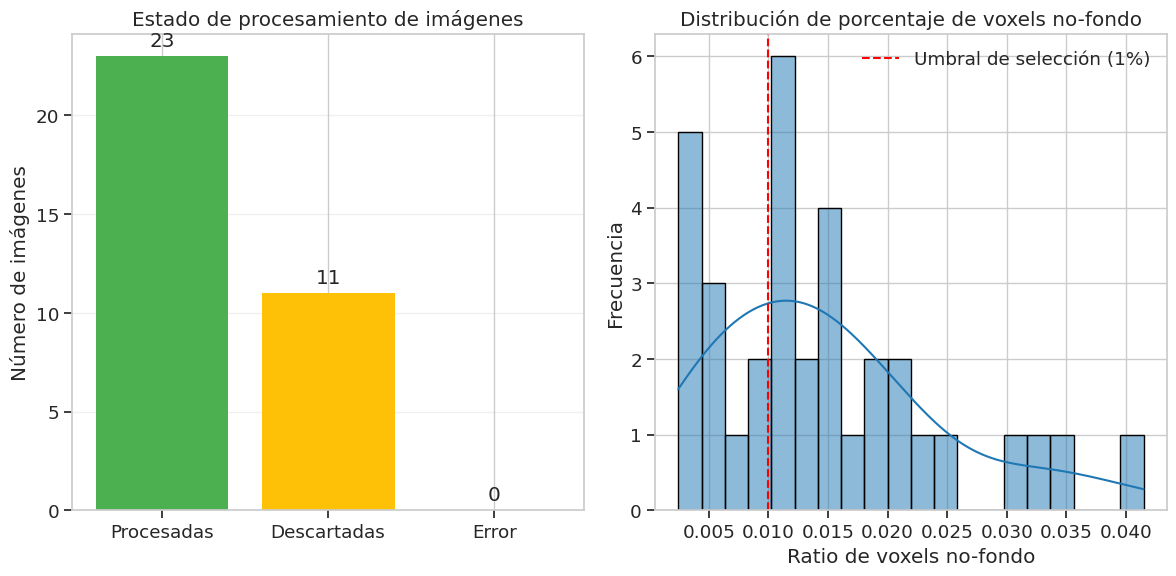

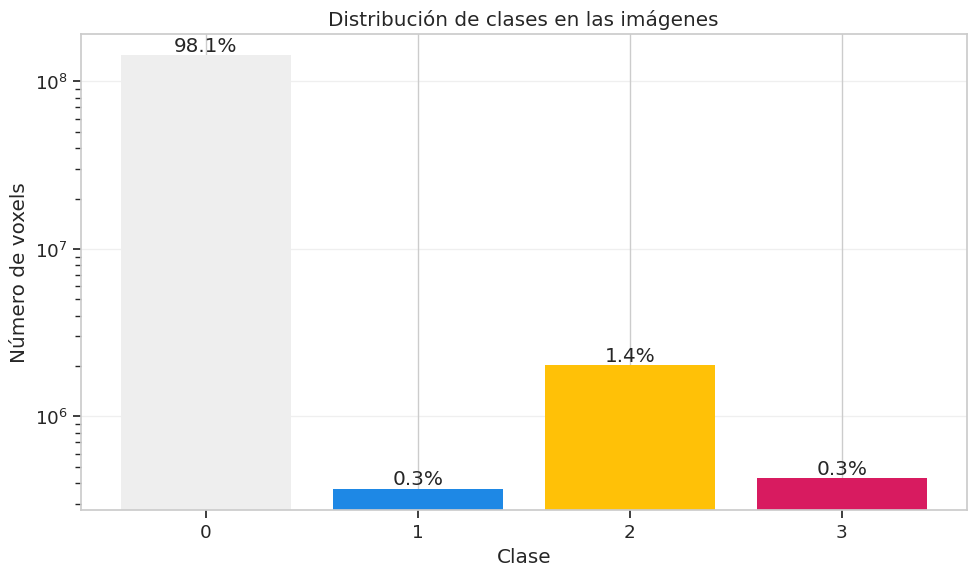

Categoría,Cantidad,Porcentaje
Total de imágenes,34,100%
Procesadas y guardadas,23,67.65%
Descartadas,11,32.35%
Con errores,0,0.00%


In [8]:
# Celda 5: Análisis y visualización de resultados
# Analizar resultados
processed_images = sum(1 for r in results if r['status'] == 'processed')
skipped_images = sum(1 for r in results if r['status'] == 'skipped')
error_images = sum(1 for r in results if r['status'] == 'error')

# Visualizar resultados
visualize_results(results)

# Mostrar estadísticas en formato HTML para mejor presentación
display(HTML(f"""
<h3>📊 Resumen del procesamiento:</h3>
<table style="width:50%; text-align:left; border-collapse:collapse; margin-bottom:15px">
  <tr style="background-color:#f0f0f0">
    <th style="padding:8px; border:1px solid #ddd">Categoría</th>
    <th style="padding:8px; border:1px solid #ddd">Cantidad</th>
    <th style="padding:8px; border:1px solid #ddd">Porcentaje</th>
  </tr>
  <tr>
    <td style="padding:8px; border:1px solid #ddd">Total de imágenes</td>
    <td style="padding:8px; border:1px solid #ddd">{total_images}</td>
    <td style="padding:8px; border:1px solid #ddd">100%</td>
  </tr>
  <tr>
    <td style="padding:8px; border:1px solid #ddd">Procesadas y guardadas</td>
    <td style="padding:8px; border:1px solid #ddd">{processed_images}</td>
    <td style="padding:8px; border:1px solid #ddd">{processed_images/total_images*100:.2f}%</td>
  </tr>
  <tr>
    <td style="padding:8px; border:1px solid #ddd">Descartadas</td>
    <td style="padding:8px; border:1px solid #ddd">{skipped_images}</td>
    <td style="padding:8px; border:1px solid #ddd">{skipped_images/total_images*100:.2f}%</td>
  </tr>
  <tr>
    <td style="padding:8px; border:1px solid #ddd">Con errores</td>
    <td style="padding:8px; border:1px solid #ddd">{error_images}</td>
    <td style="padding:8px; border:1px solid #ddd">{error_images/total_images*100:.2f}%</td>
  </tr>
</table>

<h4>⏱️ Rendimiento:</h4>
<ul>
  <li>Tiempo total de procesamiento: <b>{elapsed_time:.2f} segundos</b></li>
  <li>Tiempo promedio por imagen: <b>{elapsed_time/total_images:.2f} segundos</b></li>
  <li>Imágenes por segundo: <b>{total_images/elapsed_time:.2f}</b></li>
</ul>
"""))

# Crear registro de errores si es necesario
if error_images > 0:
    print("\n⚠️ Detalles de errores:")
    for r in results:
        if r['status'] == 'error':
            print(f"  - Imagen {r['index']}: {r['error']}")

In [10]:
# Celda 6: Guardar informe detallado
# Guardar informe detallado
report_path = f"{output_dir}/processing_report.txt"
with open(report_path, "w") as f:
    f.write(f"Informe de Procesamiento BraTS2025\n")
    f.write(f"Fecha: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Total de imágenes: {total_images}\n")
    f.write(f"Imágenes procesadas: {processed_images}\n")
    f.write(f"Imágenes descartadas: {skipped_images}\n")
    f.write(f"Imágenes con errores: {error_images}\n")
    f.write(f"Tiempo total: {elapsed_time:.2f} segundos\n\n")
    
    f.write("Detalles por imagen:\n")
    for r in sorted(results, key=lambda x: x['index']):
        if r['status'] == 'processed':
            f.write(f"✅ Imagen {r['index']}: {r['non_bg_ratio']*100:.2f}% no-fondo, original {r['original_shape']}, recortada {r['cropped_shape']}\n")
        elif r['status'] == 'skipped':
            f.write(f"❌ Imagen {r['index']}: descartada ({r['non_bg_ratio']*100:.2f}% no-fondo)\n")
        else:
            f.write(f"⚠️ Imagen {r['index']}: ERROR - {r['error']}\n")

print(f"📝 Informe detallado guardado en: {report_path}")

📝 Informe detallado guardado en: data/test//input_data_3channels/processing_report.txt


...

Archivos de imágenes procesadas: 29
Archivos de máscaras procesadas: 29

Muestra del archivo image_10.npy:
- Forma de la imagen: (182, 192, 182, 4)
- Rango de valores: [-0.5226, 14.6881]
- Forma de la máscara: (182, 192, 182, 4)
- Clases en la máscara: 4 (one-hot encoding)


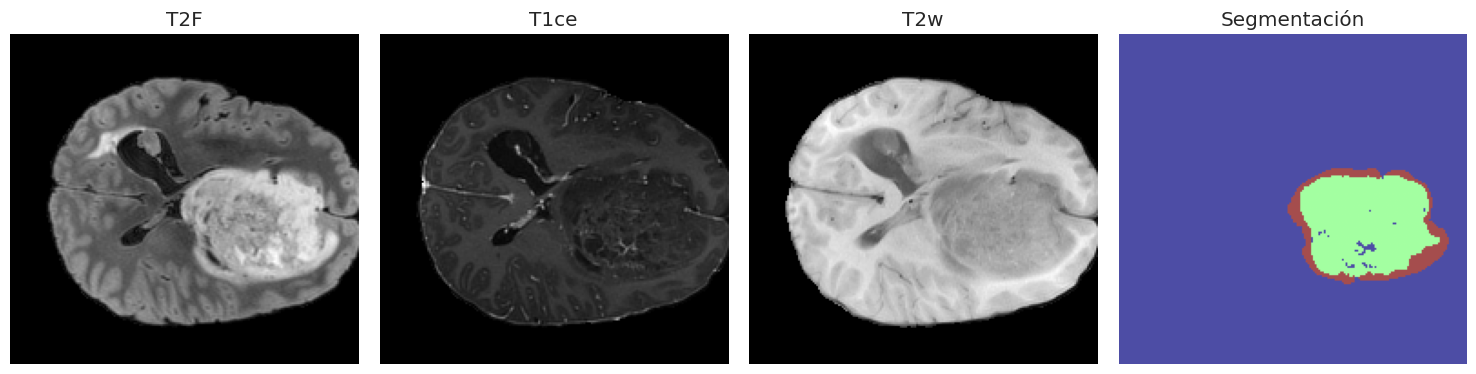

In [45]:
# Celda 7: Verificación opcional de datos procesados
# Funciones para verificar y visualizar ejemplos de los datos procesados
def check_processed_data():
    """Verifica los datos procesados y muestra estadísticas básicas"""
    processed_images_files = sorted(glob.glob(f"{images_dir}/*.npy"))
    processed_masks_files = sorted(glob.glob(f"{masks_dir}/*.npy"))
    
    print(f"Archivos de imágenes procesadas: {len(processed_images_files)}")
    print(f"Archivos de máscaras procesadas: {len(processed_masks_files)}")
    
    if len(processed_images_files) > 0:
        # Cargar una imagen aleatoria para verificar
        import random
        sample_idx = random.randint(0, len(processed_images_files)-1)
        sample_img = np.load(processed_images_files[sample_idx])
        sample_mask = np.load(processed_masks_files[sample_idx])
        
        print(f"\nMuestra del archivo {processed_images_files[sample_idx].split('/')[-1]}:")
        print(f"- Forma de la imagen: {sample_img.shape}")
        print(f"- Rango de valores: [{sample_img.min():.4f}, {sample_img.max():.4f}]")
        print(f"- Forma de la máscara: {sample_mask.shape}")
        print(f"- Clases en la máscara: {sample_mask.shape[-1]} (one-hot encoding)")
        
        # Visualizar un corte de la imagen
        slice_idx = sample_img.shape[2] // 2  # Corte central en el eje Z
        
        plt.figure(figsize=(15, 5))
        
        # Imagen t2f
        plt.subplot(141)
        plt.imshow(sample_img[:, :, slice_idx, 0], cmap='gray')
        plt.title('T2F')
        plt.axis('off')
        
        # Imagen T1ce
        plt.subplot(142)
        plt.imshow(sample_img[:, :, slice_idx, 1], cmap='gray')
        plt.title('T1ce')
        plt.axis('off')
        
        # Imagen T2w
        plt.subplot(143)
        plt.imshow(sample_img[:, :, slice_idx, 2], cmap='gray')
        plt.title('T2w')
        plt.axis('off')
        
        # Máscara (combinando todas las clases con colores diferentes)
        plt.subplot(144)
        mask_vis = np.zeros(sample_mask.shape[0:3])
        for i in range(1, sample_mask.shape[3]):  # Saltamos la clase 0 (fondo)
            mask_vis += i * sample_mask[:, :, :, i]
        
        plt.imshow(mask_vis[:, :, slice_idx], cmap='jet', alpha=0.7)
        plt.title('Segmentación')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return sample_img, sample_mask
    else:
        print("No se encontraron archivos procesados.")
        return None, None

# Esta función puede ejecutarse después de completar el procesamiento
sample_img, sample_mask = check_processed_data()

In [ ]:
#Splitting folder into train, test, and val.
input_folder = TRAIN_DATASET_PATH + '/input_data_3channels/'
output_folder = TRAIN_DATASET_PATH + '/input_data_128/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 2156 files [07:26,  4.83 files/s]
